# (공부) 빅데이터 수업 정리
> 6주차(21/10/14~21/10/19)

- toc:true
- branch: master
- badges: true
- comments: true
- author: 김하영

---

## 미니배치

- 아이디어 : 어떻게 해야 메모리를 줄일 수 있을까?

### 1. 먼저 이해해야 할 개념
- dataset : 텐서들의 pair
    ```python
    ds=torch.utils.data.TensorDataset(X,y)
    ```


- dataloader : 데이터를 가져와 여러 개의 그룹으로 나눈 후 반복 작업하는 것을 수월하게 해줌 $\to$ 배치(batch)를 만들어줌
    ```python
    dl=torch.utils.data.DataLoader(ds,batch_size=2,shuffle=True)
    ```

### 2. 예제로 보는 미니배치

#### MNIST 3/7 예제

`-` 우선 텐서로 이루어진 X,y를 만들자. 

In [3]:
import torch
from fastai.vision.all import * 

In [4]:
path = untar_data(URLs.MNIST_SAMPLE)  #데이터 다운로드

In [5]:
threes=(path/'train'/'3').ls()
sevens=(path/'train'/'7').ls()

In [6]:
seven_tensor = torch.stack([tensor(Image.open(i)) for i in sevens]).float()/255   #리스트를 텐서로!
three_tensor = torch.stack([tensor(Image.open(i)) for i in threes]).float()/255

In [7]:
three_tensor.shape, seven_tensor.shape

(torch.Size([6131, 28, 28]), torch.Size([6265, 28, 28]))

In [8]:
X=torch.vstack([seven_tensor,three_tensor]).reshape(12396,-1) #vstack으로 합치고 reshape
y=torch.tensor([0.0]*6265 + [1.0]*6131).reshape(12396,1)  #0을 seven_tensor만큼, 1을 three_tensor만큼 만들어서 tensor로 바꿔준다

In [10]:
X.shape, y.shape  #784=28*28

(torch.Size([12396, 784]), torch.Size([12396, 1]))

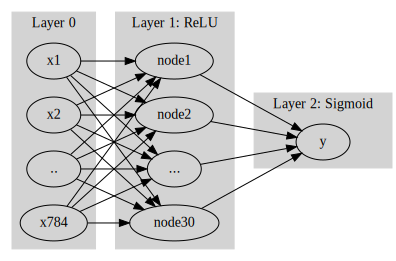

In [116]:
#collapse
gv('''
splines=line
subgraph cluster_1{
    style=filled;
    color=lightgrey;
    "x1"
    "x2"
    ".."
    "x784"
    label = "Layer 0"
}
subgraph cluster_2{
    style=filled;
    color=lightgrey;
    "x1" -> "node1"
    "x2" -> "node1"
    ".." -> "node1"
    
    "x784" -> "node1"
    "x1" -> "node2"
    "x2" -> "node2"
    ".." -> "node2"
    "x784" -> "node2"
    
    "x1" -> "..."
    "x2" -> "..."
    ".." -> "..."
    "x784" -> "..."

    "x1" -> "node30"
    "x2" -> "node30"
    ".." -> "node30"
    "x784" -> "node30"


    label = "Layer 1: ReLU"
}
subgraph cluster_3{
    style=filled;
    color=lightgrey;
    "node1" -> "y"
    "node2" -> "y"
    "..." -> "y"
    "node30" -> "y"
    label = "Layer 2: Sigmoid"
}
''')

**(1) 미니 배치 사용 안 했을 때**

In [15]:
torch.manual_seed(1)
net = torch.nn.Sequential(
    torch.nn.Linear(in_features=784,out_features=30),
    torch.nn.ReLU(),
    torch.nn.Linear(in_features=30,out_features=1)
    #torch.nn.Sigmoid()
)
loss_fn=torch.nn.BCEWithLogitsLoss()
optimizer=torch.optim.Adam(net.parameters())

In [16]:
for epoc in range(200):
    ## 1
    yhat=net(X) 
    ## 2 
    loss= loss_fn(yhat,y) 
    ## 3 : 미분
    loss.backward()
    ## 4 : 업데이트
    optimizer.step()
    net.zero_grad()    

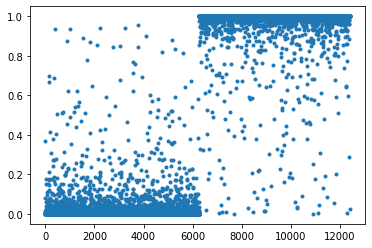

In [17]:
f=torch.nn.Sigmoid() 
plt.plot(f(yhat.data),'.')  #우리가 원하는 0,1 모양으로 나옴

**(2) 미니 배치**

`-` 네트워크 파라메터 초기화

In [18]:
torch.manual_seed(1)
net = torch.nn.Sequential(
    torch.nn.Linear(in_features=784,out_features=30),
    torch.nn.ReLU(),
    torch.nn.Linear(in_features=30,out_features=1)
    #torch.nn.Sigmoid()
)
loss_fn=torch.nn.BCEWithLogitsLoss()
optimizer=torch.optim.Adam(net.parameters())

`-` dataset

In [19]:
ds=torch.utils.data.TensorDataset(X,y)

In [20]:
ds

In [21]:
ds.tensors

(tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]),
 tensor([[0.],
         [0.],
         [0.],
         ...,
         [1.],
         [1.],
         [1.]]))

`-` dataloader

In [22]:
dl=torch.utils.data.DataLoader(ds,batch_size=2048,shuffle=True)

`-` 네트워크(아키텍처), 손실함수, 옵티마이저 

`-` 30은 node의 숫자

In [23]:
12396 / 2048 

6.052734375

`-` 총 7개의 미니배치가 만들어질것임 $\to$ 따라서 파라메터를 업데이트하는 횟수는 7 $\times$ epoc 임 (실제적으로는 6 $\times$ epoc) 

In [24]:
200/6

33.333333333333336

`-` 파라메터를 200번 업데이트 하고 싶음  
`-` 1번 에폭이 돌 때 6번 반복 $\to$ 200/6=33.3333...

In [25]:
for epoc in range(33): 
    for xx,yy in dl:  ### 총 7번돌면 끝나는 for 
        ## 1 
        yyhat=net(xx)
        ## 2 
        loss= loss_fn(yyhat,yy) 
        ## 3 
        loss.backward()
        ## 4 
        optimizer.step()
        net.zero_grad() 

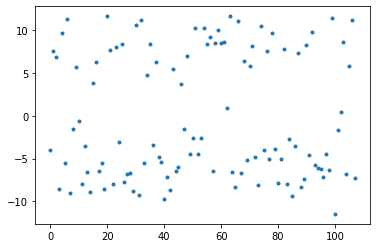

In [26]:
plt.plot(yyhat.data,'.')

`-` 배치사이즈를 다시 확인해보자. 

In [82]:
for xx,yy in dl: 
    print(xx.shape,yy.shape)

torch.Size([2048, 784]) torch.Size([2048, 1])
torch.Size([2048, 784]) torch.Size([2048, 1])
torch.Size([2048, 784]) torch.Size([2048, 1])
torch.Size([2048, 784]) torch.Size([2048, 1])
torch.Size([2048, 784]) torch.Size([2048, 1])
torch.Size([2048, 784]) torch.Size([2048, 1])
torch.Size([108, 784]) torch.Size([108, 1])


`-` 마지막이 108개이므로 108개의 y만 그려짐 

In [83]:
list(net.parameters())

[Parameter containing:
 tensor([[ 0.0184, -0.0158, -0.0069,  ...,  0.0068, -0.0041,  0.0025],
         [-0.0274, -0.0224, -0.0309,  ..., -0.0029,  0.0013, -0.0167],
         [ 0.0282, -0.0095, -0.0340,  ..., -0.0141,  0.0056, -0.0335],
         ...,
         [ 0.0267,  0.0186, -0.0326,  ...,  0.0047, -0.0072, -0.0301],
         [-0.0190,  0.0291,  0.0221,  ...,  0.0067,  0.0206,  0.0151],
         [ 0.0226,  0.0331,  0.0182,  ...,  0.0150,  0.0278, -0.0073]],
        requires_grad=True),
 Parameter containing:
 tensor([-0.0119,  0.0269,  0.0336, -0.0091,  0.1124,  0.0174,  0.0163, -0.0248,
          0.0344,  0.0378, -0.0179,  0.0448,  0.0205,  0.0758,  0.0097,  0.0005,
          0.0353,  0.0356,  0.0543,  0.0156,  0.0577,  0.0128,  0.0486,  0.0669,
         -0.0036, -0.0301,  0.1002,  0.0440,  0.0642,  0.0564],
        requires_grad=True),
 Parameter containing:
 tensor([[ 0.2202,  0.1959,  0.2053,  0.1672, -0.2607, -0.0727, -0.1659,  0.1090,
          -0.2555, -0.2506,  0.1318, -0.184

`-` 만약 잘 추정되었다면 아래의 결과가 잘 나와야겠지?

In [27]:
net(X)

tensor([[-7.6275],
        [-0.9907],
        [-8.1248],
        ...,
        [ 7.8302],
        [11.8567],
        [ 9.7307]], grad_fn=<AddmmBackward>)

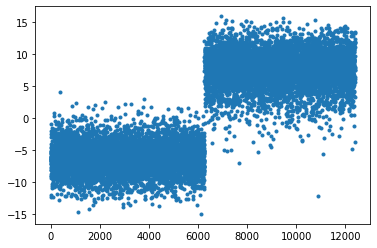

In [29]:
plt.plot(net(X).data,'.')

- (?) 왜 아래 그래프는 0, 1로 떨어지지 않았지? 까먹음

---

## 드랍아웃

- 아이디어 : parameter 수가 많아져서 overfitting 현상 발생 $\to$ 변수를 줄이자 

In [30]:
import torch 
import matplotlib.pyplot as plt 

In [31]:
torch.manual_seed(5) 
X=torch.linspace(0,1,100).reshape(100,1)
y=torch.randn(100).reshape(100,1)*0.01

In [32]:
torch.manual_seed(1) # 초기가중치를 똑같이 
net=torch.nn.Sequential(
    torch.nn.Linear(in_features=1,out_features=512), 
    torch.nn.ReLU(),
    torch.nn.Linear(in_features=512,out_features=1)) 
optimizer= torch.optim.Adam(net.parameters())
loss_fn= torch.nn.MSELoss()

**오버피팅 예시**

In [33]:
for epoc in range(1000): 
    ## 1 
    yhat=net(X) 
    ## 2 
    loss=loss_fn(yhat,y) 
    ## 3 
    loss.backward()
    ## 4 
    optimizer.step()
    net.zero_grad() 

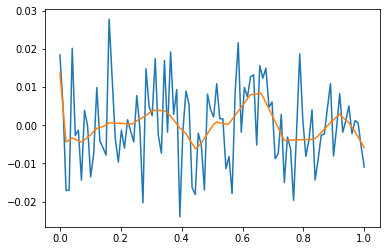

In [34]:
plt.plot(X,y) 
plt.plot(X,yhat.data)

`-` train/test 구분하여 예측해보자

In [35]:
X1=X[:80]
y1=y[:80]
X2=X[80:]
y2=y[80:] 

In [36]:
torch.manual_seed(1) 
net=torch.nn.Sequential(
    torch.nn.Linear(in_features=1,out_features=512), 
    torch.nn.ReLU(),
    torch.nn.Linear(in_features=512,out_features=1)) 
optimizer= torch.optim.Adam(net.parameters())
loss_fn= torch.nn.MSELoss()

In [37]:
for epoc in range(1000): 
    ## 1 
    y1hat=net(X1) 
    ## 2 
    loss=loss_fn(y1hat,y1) 
    ## 3 
    loss.backward()
    ## 4 
    optimizer.step() 
    net.zero_grad() 

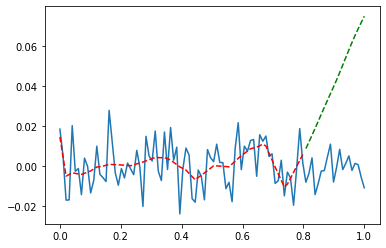

In [38]:
plt.plot(X,y)
plt.plot(X1,net(X1).data,'--r') 
plt.plot(X2,net(X2).data,'--g') 

**드랍아웃**

`-` 드랍아웃은 좋은 node들만 업데이트 할 수 있도록 하는 것임  
`-` Dropout(0.8)은 에폭마다 80%를 날리고 좋은 node 20%만 학습을 진행하는 것임  
`-` 유의할 것은 평가할 때 모든 node를 사용해야 한다는 것!

In [39]:
torch.manual_seed(1) 
net=torch.nn.Sequential(
    torch.nn.Linear(in_features=1,out_features=512), 
    torch.nn.ReLU(),
    torch.nn.Dropout(0.8),
    torch.nn.Linear(in_features=512,out_features=1)) 
optimizer= torch.optim.Adam(net.parameters())
loss_fn= torch.nn.MSELoss()

In [40]:
for epoc in range(1000): 
    ## 1 
    y1hat=net(X1) 
    ## 2 
    loss=loss_fn(y1hat,y1) 
    ## 3 
    loss.backward()
    ## 4 
    optimizer.step() 
    net.zero_grad() 

`-` 평가모드 안 했을 때

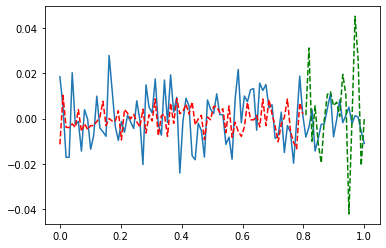

In [41]:
plt.plot(X,y)
plt.plot(X1,net(X1).data,'--r') 
plt.plot(X2,net(X2).data,'--g') 

`-` 평가모드 했을 때

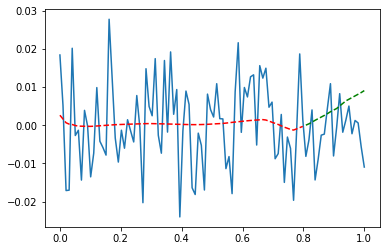

In [42]:
net.eval()
plt.plot(X,y)
plt.plot(X1,net(X1).data,'--r') 
plt.plot(X2,net(X2).data,'--g') 

( ! ) 그런데 두 방법 중 어느 것이 더 나은지는 말하기 어려움. 비교를 해보자!

---

## pytorch + fastai

- 아이디어 : 위와 같은 코드를 합해서 비교하려고 하니 너무 복잡하다 $\to$ pytorch+fastai 조합으로 해결!

In [43]:
X_tr=X[:80]
y_tr=y[:80]
X_val=X[80:]
y_val=y[80:] 

In [44]:
ds1=torch.utils.data.TensorDataset(X_tr,y_tr) 
ds2=torch.utils.data.TensorDataset(X_val,y_val) 

In [45]:
dl1 = torch.utils.data.DataLoader(ds1, batch_size=80) 
dl2 = torch.utils.data.DataLoader(ds2, batch_size=20) 

`-` 데이터로더스(데이터로더의 집합)를 만든다. 

In [46]:
from fastai.vision.all import * 

In [47]:
dls=DataLoaders(dl1,dl2) 

**드랍아웃 제외버전**

In [48]:
torch.manual_seed(1) 
net_fastai = torch.nn.Sequential(
    torch.nn.Linear(in_features=1, out_features=512),
    torch.nn.ReLU(),
    #torch.nn.Dropout(0.8),
    torch.nn.Linear(in_features=512, out_features=1)) 
#optimizer 
loss_fn=torch.nn.MSELoss()

`-` 러너오브젝트 (for문 대신돌려주는 오브젝트) 

In [49]:
lrnr= Learner(dls,net_fastai,opt_func=Adam,loss_func=loss_fn) 

`-` 에폭만 설정하고 바로 학습

In [71]:
#collapse-output
lrnr.fit(1000)

epoch,train_loss,valid_loss,time
0,1.277156,0.491314,00:00
1,1.277145,0.455286,00:00
2,1.275104,0.444275,00:00
3,1.274429,0.465787,00:00
4,1.273436,0.507203,00:00
5,1.272421,0.548102,00:00
6,1.271840,0.561292,00:00
7,1.271377,0.549409,00:00
8,1.270855,0.530416,00:00
9,1.270437,0.520700,00:00


`-` loss들도 에폭별로 기록되어 있음 

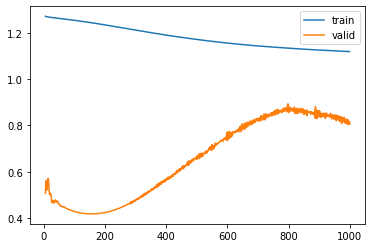

In [72]:
lrnr.recorder.plot_loss()

`-` net_fastai에도 파라메터가 업데이트 되어있음 

In [76]:
# list(net_fastai.parameters())
# list(net1.parameters()) #비교용, cuda 없음. cpu학습

- 리스트를 확인해보면 device가 cuda임
- net_fastai 의 파라메터가 알아서 GPU로 옮겨져서 학습됨. 

`-` 플랏 

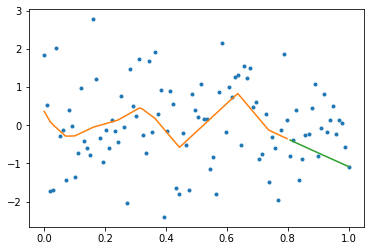

In [78]:
net_fastai.to("cpu") #같은 디바이스에 올려주기
plt.plot(X,y,'.')
plt.plot(X_tr,net_fastai(X_tr).data) 
plt.plot(X_val,net_fastai(X_val).data) 

**드랍아웃 추가버전**

In [79]:
torch.manual_seed(1) 
net_fastai = torch.nn.Sequential(
    torch.nn.Linear(in_features=1, out_features=512),
    torch.nn.ReLU(),
    torch.nn.Dropout(0.8),
    torch.nn.Linear(in_features=512, out_features=1)) 
#optimizer 
loss_fn=torch.nn.MSELoss()

In [80]:
lrnr= Learner(dls,net_fastai,opt_func=Adam,loss_func=loss_fn) 

In [83]:
#collapse-output
lrnr.fit(1000)

epoch,train_loss,valid_loss,time
0,1.247709,0.416773,00:00
1,1.246509,0.416574,00:00
2,1.250404,0.416343,00:00
3,1.254794,0.415792,00:00
4,1.255322,0.415081,00:00
5,1.262187,0.414570,00:00
6,1.257735,0.414416,00:00
7,1.263794,0.414380,00:00
8,1.273511,0.414440,00:00
9,1.280515,0.414707,00:00


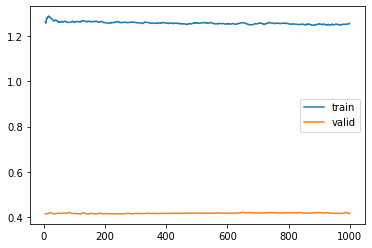

In [84]:
lrnr.recorder.plot_loss()

In [85]:
# list(net_fastai.parameters())

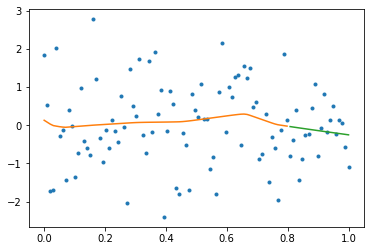

In [86]:
net_fastai.to("cpu") 
plt.plot(X,y,'.')
plt.plot(X_tr,net_fastai(X_tr).data) 
plt.plot(X_val,net_fastai(X_val).data) 